# Week 3 CNN Cancer Detection Kaggle Mini-Project

## Description

This notebook outlines the analysis and model building procedure for the Kaggle competition found at https://www.kaggle.com/c/histopathologic-cancer-detection/overview. The goal is to determine the presence of cancer in images taken from pathology scans. This is a binary image classification problem. The images are 96x96 pixels resolution with 3 channel RGB coloring. There are x number of training samples and x number of test samples.

Link to Github: https://github.com/WyattHough/msds/blob/main/deep_learning/Week%203/Week3.ipynb

In [1]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

import keras
from keras import backend as K 
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16

import tensorflow as tf
import os
from skimage import io

2023-06-24 12:13:57.398317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exploratory Data Analysis

In [2]:
test_path = '../../../data/histopathologic-cancer-detection/test/'
train_path = '../../../data/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../../../data/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../../../data/histopathologic-cancer-detection/train_labels.csv')

In [4]:
train_df = pd.read_csv('../../../data/histopathologic-cancer-detection/train_labels.csv')
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
train_df.isnull().sum()

id       0
label    0
dtype: int64

In [7]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

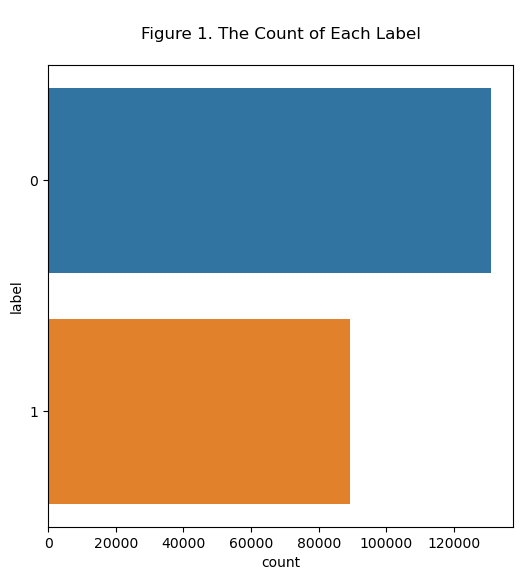

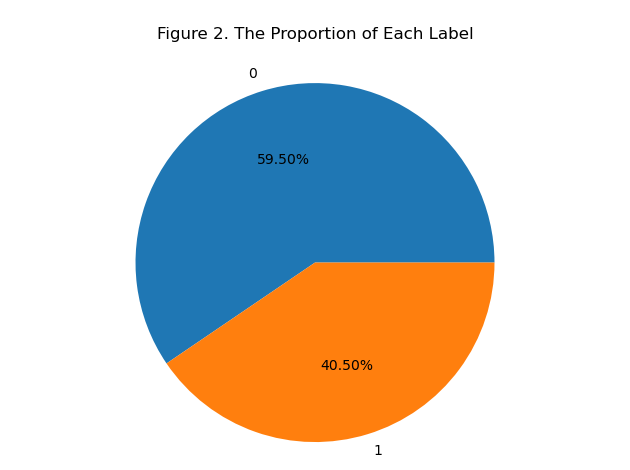

In [9]:
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=train_df, y='label', ax=ax).set(title='\nFigure 1. The Count of Each Label\n')

# plot the proportion of each label
labels = train_df['label'].unique().tolist()
counts = train_df['label'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 2. The Proportion of Each Label\n")
plt.tight_layout()
plt.show()

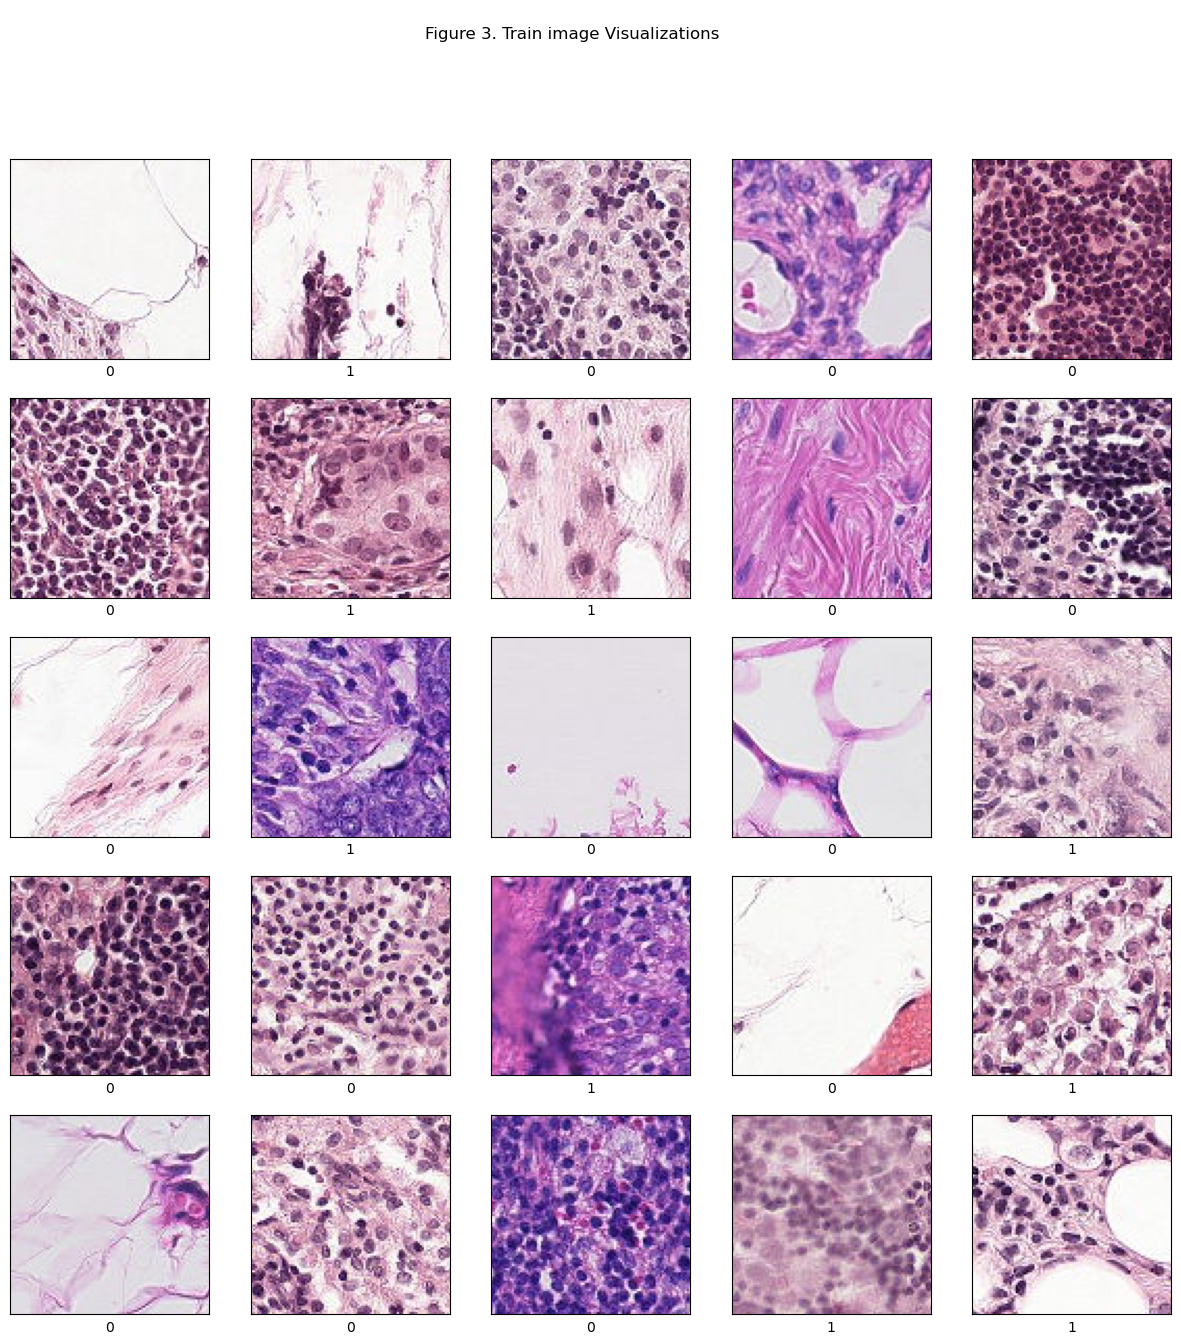

In [10]:
def append_tif(string):
    return string + ".tif"
train_df["id"] = train_df["id"].apply(append_tif)
train_df["label"] = train_df["label"].astype(str)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    file = str(train_path + train_df.id[i])
    image = io.imread(file)
    ax.imshow(image)
    ax.set(xticks=[], yticks=[], xlabel = train_df.label[i])
fig.suptitle('\nFigure 3. Train image Visualizations') 
plt.show() 

In [11]:
SAMPLE = 80000
train1 = train_df[train_df["label"] == "0"].sample(SAMPLE)
train2 = train_df[train_df["label"] == "1"].sample(SAMPLE)
train_dt = pd.concat([train1, train2], axis=0).reset_index(drop=True)
train_dt["label"].value_counts()

0    80000
1    80000
Name: label, dtype: int64

In [12]:
train_data, valid_data = train_test_split(train_dt,                                                       
                                   test_size=0.2, 
                                   shuffle=True, stratify=train_dt["label"])

# check value count in train and validation set
print(train_data["label"].value_counts())
print(valid_data["label"].value_counts())

0    64000
1    64000
Name: label, dtype: int64
1    16000
0    16000
Name: label, dtype: int64


In [17]:
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset                           
                             zoom_range = 0.2, # Randomly zoom image 
                             rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip = True,  # randomly flip images
                             rescale=1./255)    # multiply the data by the value provided

train_generator = datagen.flow_from_dataframe(
                            dataframe=train_data,
                            directory=train_path,
                            x_col="id",
                            y_col="label",                            
                            class_mode="binary",
                            target_size=(64,64))
validation_generator = datagen.flow_from_dataframe(
                            dataframe=valid_data,
                            directory=train_path,
                            x_col="id",
                            y_col="label",
                            class_mode="binary",
                            target_size=(64,64))

Found 128000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.


## Model and Results

In [15]:
model = Sequential()
# first convolutional layer
model.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
# third convolutional layer
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Out layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

2023-06-24 12:20:53.897856: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       2

In [16]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator,
                    epochs = 2 , 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data = validation_generator,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/2


2023-06-24 13:23:36.067784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4000/4000 [==============================] - 2304s 576ms/step - loss: 0.3379 - accuracy: 0.8556 - val_loss: 0.3204 - val_accuracy: 0.8598
Epoch 2/2
4000/4000 [==============================] - 2225s 556ms/step - loss: 0.3233 - accuracy: 0.8629 - val_loss: 0.3008 - val_accuracy: 0.8712


2023-06-24 15:54:51.906018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-06-24 15:54:54.087023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: my_model1/assets


INFO:tensorflow:Assets written to: my_model1/assets


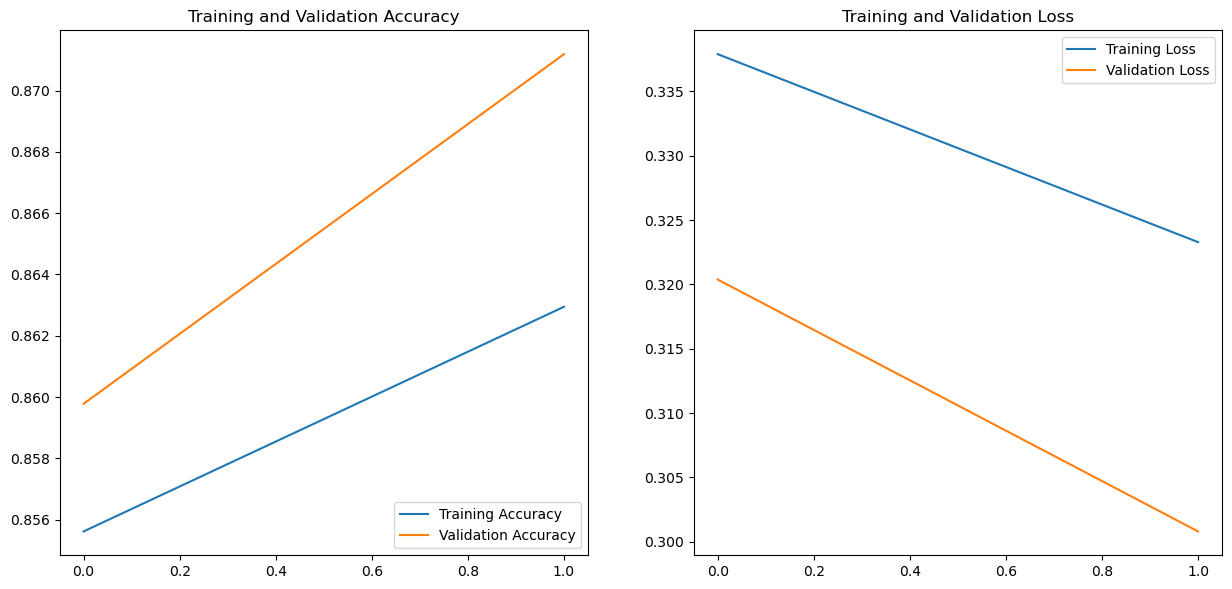

In [23]:
model.save("my_model1")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
print(validation_generator.class_indices)
y_true = validation_generator.classes

{'0': 0, '1': 1}


In [26]:
val_loss1, val_acc1 = model.evaluate(validation_generator)
print('val_loss_model1:', val_loss1)
print('val_acc_model1:', val_acc1)
predictions1 = model.predict(validation_generator, verbose=1)
predictions1

   1/1000 [..............................] - ETA: 2:47 - loss: 0.3581 - accuracy: 0.9062

2023-06-24 15:57:15.028664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 185s 185ms/step - loss: 0.3012 - accuracy: 0.8697
val_loss_model1: 0.3012183904647827
val_acc_model1: 0.8697187304496765


2023-06-24 16:00:37.319430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 320s 319ms/step


array([[0.98914576],
       [0.98416406],
       [0.00954657],
       ...,
       [0.00783001],
       [0.6073959 ],
       [0.7367535 ]], dtype=float32)

AUC: 0.5001154433593751


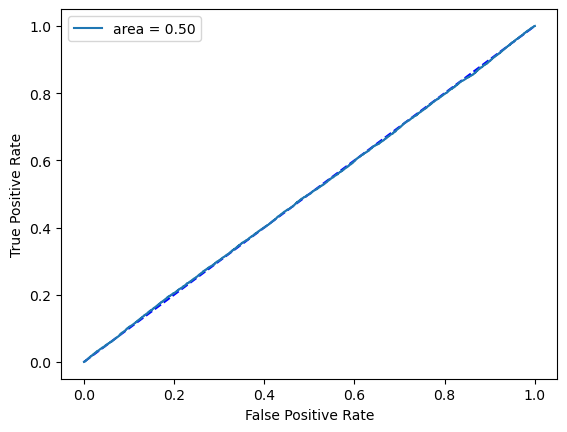

In [27]:
fpr1, tpr1, thresholds1 = roc_curve(y_true, predictions1, pos_label=1)
auc_score1 = auc(fpr1, tpr1)
print(f"AUC: {auc_score1}")
plt.plot([0,1], [0,1], linestyle='--', color='blue')
plt.plot(fpr1, tpr1, label='area = {:.2f}'.format(auc_score1))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

                            precision    recall  f1-score   support

 no_tumor_tissue (Class 0)       0.50      0.47      0.48     16000
has_tumor_tissue (Class 1)       0.50      0.53      0.51     16000

                  accuracy                           0.50     32000
                 macro avg       0.50      0.50      0.50     32000
              weighted avg       0.50      0.50      0.50     32000



<Axes: >

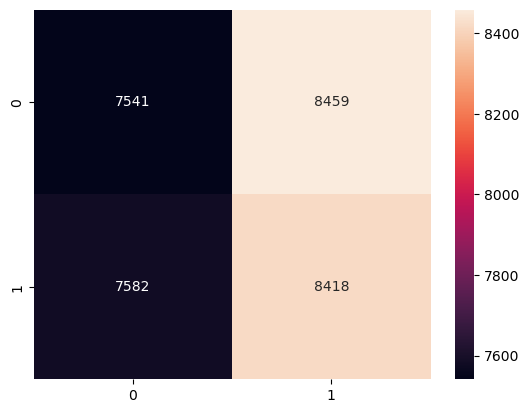

In [29]:
y_pred1 = np.where(predictions1 > 0.5, 1, 0)
print(classification_report(y_true, y_pred1, target_names = ['no_tumor_tissue (Class 0)','has_tumor_tissue (Class 1)']))
cm1 = confusion_matrix(y_true, y_pred1)
sns.heatmap(cm1, annot=True, fmt=".0f")

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_df = pd.DataFrame({'id':os.listdir('../../../data/histopathologic-cancer-detection/test/')})
test_generator = test_datagen.flow_from_dataframe(
                            dataframe=test_df,
                            directory=test_path,
                            x_col="id",
                            y_col=None,
                            shuffle=False,
                            class_mode=None,
                            target_size=(64,64))
t_predictions = model.predict(test_generator, verbose=1)

Found 57458 validated image filenames.


/home/wyatt/miniconda3/envs/msds/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 57458 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
2023-06-24 16:59:38.728071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1796/1796 [==============================] - 157s 87ms/step


## Conclusion

The model was able to classify cancer with 50% accuracy which is about the level of guessing, this was because I trained with very few epochs due to hardware limitation. The Adam optimizer allowed the model to converge faster and was important to the model development. We could have used a pretrained network with initialized weights before starting to decrease training time, due to harware restrictions the training time between each epoch was very large so the model was trained with a small number of epochs. If the number of epochs were increased we could have seen better model performance.